# Understanding Matrix Factorization Step by Step

**Author**: Elias Abou Haydar

## Theoretical Background

Before diving into the implementation, let's understand what Matrix Factorization (MF) does in the context of recommender systems:

### The Basic Concept
Matrix Factorization aims to decompose a large user-item interaction matrix R into two smaller matrices: a user matrix U and an item matrix V. The key idea is that each user and item can be represented by a vector of "latent factors" - hidden characteristics that determine preferences and similarities.

For example, in a movie recommender system, these latent factors might represent concepts like:
- How much a user likes action scenes
- How serious or comedic a movie is
- The level of special effects
- The emotional depth of the plot

### Mathematical Foundation
If we have:
- m users and n items
- k latent factors (where k << m and k << n)
- A rating matrix R (m × n)

We want to find:
- User matrix U (m × k)
- Item matrix V (n × k)

Such that: R ≈ UV^T

## Implementation Steps

### Step 1: Matrix Initialization
The first crucial step is properly initializing our matrices. We'll examine this process in detail.

#### Why Small Random Values?
We initialize both U and V with small random values (using normal distribution with small scale) because:
1. Large initial values can lead to exploding gradients
2. Small values help the algorithm converge more smoothly
3. Random initialization breaks symmetry in the learning process

In [1]:
import numpy as np

def initialize_matrices(user_item_matrix, num_factors):
    """Initialize user and item matrices for factorization."""
    num_users, num_items = user_item_matrix.shape
    
    # Initialize matrices with small random values
    user_factors = np.random.normal(scale=1./num_factors, 
                                  size=(num_users, num_factors))
    item_factors = np.random.normal(scale=1./num_factors, 
                                  size=(num_items, num_factors))
    
    # Get indices of known ratings
    user_item_indices = np.where(user_item_matrix > 0)
    
    return user_factors, item_factors, user_item_indices

# Example usage
test_matrix = np.array([
    [5, 0, 2, 0],
    [0, 3, 0, 1],
    [4, 0, 0, 2]
])

user_f, item_f, indices = initialize_matrices(test_matrix, num_factors=3)

### Step 2: Error Computation
Once we have our initial matrices, we need to measure how well they approximate our original matrix.

#### The Error Calculation Process:
1. For each known rating rᵤᵢ:
   - Predict rating: r̂ᵤᵢ = uᵤ · vᵢ (dot product)
   - Calculate error: eᵤᵢ = rᵤᵢ - r̂ᵤᵢ
2. Aggregate errors using RMSE (Root Mean Square Error)

This gives us a baseline for how well our factorization is performing.

In [2]:
def compute_error(user_item_matrix, user_factors, item_factors, user_item_indices):
    """Calculate prediction error for known ratings."""
    total_error = 0
    
    # For each known rating
    for idx in range(len(user_item_indices[0])):
        user_idx = user_item_indices[0][idx]
        item_idx = user_item_indices[1][idx]
        
        # Get actual rating
        actual = user_item_matrix[user_idx, item_idx]
        
        # Compute predicted rating
        predicted = np.dot(user_factors[user_idx], item_factors[item_idx])
        
        # Add squared error
        error = actual - predicted
        total_error += error ** 2
    
    # Compute RMSE
    rmse = np.sqrt(total_error / len(user_item_indices[0]))
    return rmse


### Step 3: Gradient Updates
Now we need to improve our factorization using gradient descent. This is where the real learning happens.

#### The Learning Process:
1. For each known rating:
   - Calculate the prediction error
   - Update user factors in the direction that reduces error
   - Update item factors in the direction that reduces error

#### The Mathematics Behind Updates:
For each rating rᵤᵢ:
1. Error term: eᵤᵢ = rᵤᵢ - uᵤ · vᵢ
2. Update rules:
   - uᵤ ← uᵤ + α(eᵤᵢvᵢ)
   - vᵢ ← vᵢ + α(eᵤᵢuᵤ)

Where α is the learning rate that controls how big steps we take.

In [3]:
def update_factors(user_item_matrix, user_factors, item_factors, 
                  user_item_indices, learning_rate):
    """Perform one iteration of gradient updates."""
    for idx in range(len(user_item_indices[0])):
        user_idx = user_item_indices[0][idx]
        item_idx = user_item_indices[1][idx]
        
        # Compute error
        actual = user_item_matrix[user_idx, item_idx]
        predicted = np.dot(user_factors[user_idx], item_factors[item_idx])
        error = actual - predicted
        
        # Update user and item factors
        user_factors[user_idx] += learning_rate * error * item_factors[item_idx]
        item_factors[item_idx] += learning_rate * error * user_factors[user_idx]
    
    return user_factors, item_factors

### Step 4: Regularization
Regularization is crucial for preventing overfitting and ensuring our model generalizes well.

#### Why We Need Regularization:
1. Without constraints, factor values can become very large
2. Large factors can lead to overfitting to training data
3. Regularization penalizes large values, encouraging simpler models

#### The Mathematics of Regularization:
We modify our update rules to include a regularization term λ:
1. uᵤ ← uᵤ + α(eᵤᵢvᵢ - λuᵤ)
2. vᵢ ← vᵢ + α(eᵤᵢuᵤ - λvᵢ)

This effectively pulls factor values toward zero, unless there's strong evidence they should be large.

In [4]:
def update_factors_with_regularization(user_item_matrix, user_factors, item_factors, 
                                     user_item_indices, learning_rate, regularization):
    """Perform one iteration of regularized gradient updates."""
    for idx in range(len(user_item_indices[0])):
        user_idx = user_item_indices[0][idx]
        item_idx = user_item_indices[1][idx]
        
        # Compute error
        actual = user_item_matrix[user_idx, item_idx]
        predicted = np.dot(user_factors[user_idx], item_factors[item_idx])
        error = actual - predicted
        
        # Compute gradients with regularization
        user_grad = error * item_factors[item_idx] - regularization * user_factors[user_idx]
        item_grad = error * user_factors[user_idx] - regularization * item_factors[item_idx]
        
        # Update factors
        user_factors[user_idx] += learning_rate * user_grad
        item_factors[item_idx] += learning_rate * item_grad
    
    return user_factors, item_factors

### Step 5: Final Optimizations
The final version includes several optimizations for better performance.

#### Key Improvements:
1. **Random Shuffling**
   - Why: Prevents systematic biases in updates
   - How: Randomly permute the order of updates each iteration

2. **Progress Monitoring**
   - Track RMSE over iterations
   - Helps identify convergence
   - Useful for early stopping

3. **Efficient Processing**
   - Only process non-zero elements
   - Keeps computation focused on known ratings

Iteration 10: RMSE = 3.2923
Iteration 20: RMSE = 3.2795
Iteration 30: RMSE = 3.2249
Iteration 40: RMSE = 2.9646
Iteration 50: RMSE = 2.2208
Iteration 60: RMSE = 1.5837
Iteration 70: RMSE = 1.3360
Iteration 80: RMSE = 1.2205
Iteration 90: RMSE = 1.1452
Iteration 100: RMSE = 1.0864
Iteration 110: RMSE = 1.0367
Iteration 120: RMSE = 0.9922
Iteration 130: RMSE = 0.9520
Iteration 140: RMSE = 0.9155
Iteration 150: RMSE = 0.8814
Iteration 160: RMSE = 0.8500
Iteration 170: RMSE = 0.8210
Iteration 180: RMSE = 0.7944
Iteration 190: RMSE = 0.7697
Iteration 200: RMSE = 0.7470
Iteration 210: RMSE = 0.7257
Iteration 220: RMSE = 0.7062
Iteration 230: RMSE = 0.6878
Iteration 240: RMSE = 0.6708
Iteration 250: RMSE = 0.6551
Iteration 260: RMSE = 0.6402
Iteration 270: RMSE = 0.6262
Iteration 280: RMSE = 0.6132
Iteration 290: RMSE = 0.6008
Iteration 300: RMSE = 0.5894
Iteration 310: RMSE = 0.5787
Iteration 320: RMSE = 0.5681
Iteration 330: RMSE = 0.5585
Iteration 340: RMSE = 0.5496
Iteration 350: RMSE = 0

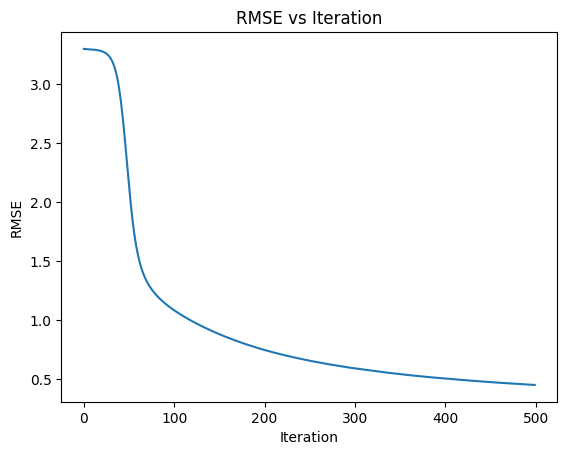

In [5]:
def matrix_factorization(user_item_matrix, num_factors=3, learning_rate=0.001, 
                        regularization=0.1, iterations=100, verbose=True):
    """Complete matrix factorization implementation."""
    # Initialize matrices
    user_factors, item_factors, user_item_indices = initialize_matrices(
        user_item_matrix, num_factors)
    
    errors = []
    
    for iteration in range(iterations):
        # Shuffle indices
        indices = np.arange(len(user_item_indices[0]))
        np.random.shuffle(indices)
        
        # Update factors
        for idx in indices:
            user_idx = user_item_indices[0][idx]
            item_idx = user_item_indices[1][idx]
            
            # Compute error
            actual = user_item_matrix[user_idx, item_idx]
            predicted = np.dot(user_factors[user_idx], item_factors[item_idx])
            error = actual - predicted
            
            # Update with regularization
            user_grad = error * item_factors[item_idx] - regularization * user_factors[user_idx]
            item_grad = error * user_factors[user_idx] - regularization * item_factors[item_idx]
            
            user_factors[user_idx] += learning_rate * user_grad
            item_factors[item_idx] += learning_rate * item_grad
        
        # Compute and store error
        rmse = compute_error(user_item_matrix, user_factors, item_factors, user_item_indices)
        errors.append(rmse)
        
        if verbose and (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: RMSE = {rmse:.4f}")
    
    return user_factors, item_factors, errors

def generate_interaction_matrix(feedback_type='implicit', num_users=100, num_items=50, 
                              interaction_density=0.1, rating_scale=(1, 5)):
    """Generate synthetic user-item interaction matrices.
    
    Args:
        feedback_type (str): Type of feedback ('implicit' or 'explicit')
        num_users (int): Number of users
        num_items (int): Number of items
        interaction_density (float): Density of interactions (0-1)
        rating_scale (tuple): Range for ratings (min, max)
        
    Returns:
        np.ndarray: Generated interaction matrix
    """
    if feedback_type == 'implicit':
        # Create binary interaction matrix
        random_matrix = np.random.rand(num_users, num_items)
        return (random_matrix < interaction_density).astype(int)
    else:
        # Create explicit rating matrix
        matrix = np.zeros((num_users, num_items))
        for i in range(num_users):
            for j in range(num_items):
                if np.random.rand() < interaction_density:
                    matrix[i, j] = np.random.randint(rating_scale[0], rating_scale[1] + 1)
        return matrix


# Create test matrix
test_matrix = generate_interaction_matrix(feedback_type='explicit', num_users=10000, interaction_density=0.05)

# Run factorization
user_f, item_f, errors = matrix_factorization(
    test_matrix,
    num_factors=10,
    iterations=500
)

# Show results
predicted_matrix = np.dot(user_f, item_f.T)

print("Original Matrix:")
print(test_matrix)
print("\nPredicted Matrix:")
print(predicted_matrix.round(2))

# Plot error progression
import matplotlib.pyplot as plt
plt.plot(errors)
plt.title('RMSE vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()

## Practical Considerations

### Hyperparameter Selection
1. **Number of Factors (k)**
   - Too few: Can't capture complex patterns
   - Too many: Risk of overfitting
   - Typical range: 20-100 for real applications

2. **Learning Rate (α)**
   - Too high: Can cause divergence
   - Too low: Slow convergence
   - Often start with 0.001 and adjust

3. **Regularization (λ)**
   - Too high: Underfitting
   - Too low: Overfitting
   - Often start with 0.1 and tune

### Convergence Monitoring
Watch for:
1. Decreasing RMSE over iterations
2. Stabilization of updates
3. No oscillation in error values

### Performance Optimization
Tips for better performance:
1. Vectorize operations where possible
2. Use mini-batch updates for large datasets
3. Implement early stopping
4. Consider parallel processing for large scales